In [1]:
from dataset_slide import *
import torch
import torch.nn as nn

import numpy as np

from scipy.stats import uniform, randint

from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
import xgboost as xgb

Loading...
Finished Loading...


In [2]:
person_order = {'F1_Interaction_1': {'P2': 1, 'P1': 1, 'P3': 2},
 'F1_Interaction_2': {'P2': 1, 'P1': 1, 'P3': 2},
 'F2_Interaction_1': {'P4': 1, 'P5': 3},
 'F2_Interaction_2': {'P4': 1},
 'F3_Interaction_1': {'P8': 3, 'P6': 1, 'P7': 1},
 'F3_Interaction_2': {'P6': 1, 'P7': 1},
 'F4_Interaction_1': {'P14': 2,
  'P12': 1,
  'P11': 1,
  'P10': 1,
  'P9': 1,
  'P13': 3},
 'F4_Interaction_2': {'P12': 1,
  'P11': 1,
  'P10': 1,
  'P9': 1,
  'P13': 3},
 'F5_Interaction_1': {'P16': 2, 'P15': 1},
 'F5_Interaction_2': {'P16': 2, 'P15': 1},
 'F6_Interaction_1': {'P19': 3, 'P18': 1, 'P17': 1},
 'F6_Interaction_2': {'P19': 3, 'P18': 1, 'P17': 1},
 'F7_Interaction_1': {'P22': 3,
  'P20': 1,
  'P21': 1,
  'P23': 2},
 'F8_Interaction_1': {'P24': 1, 'P25': 3},
 'F8_Interaction_2': {'P24': 1, 'P25': 3},
 'F8_Interaction_3': {'P24': 1, 'P25': 3},
 'F10_Interaction_1': {'P27': 1, 'P28': 1},
 'F11_Interaction_1': {'P29': 1, 'P30': 2},
 'F11_Interaction_2': {'P29': 1, 'P30': 2},
 'F13_Interaction_1': {'P32': 1, 'P33': 2},
 'F17_Interaction_1': {'P37': 1, 'P38': 2},
 'F17_Interaction_2': {'P37': 1, 'P38': 2}}


group_nums = {1: ['F2_Interaction_2'],
 2: ['F2_Interaction_1',
  'F3_Interaction_2',
  'F5_Interaction_1',
  'F5_Interaction_2',
  'F8_Interaction_1',
  'F8_Interaction_2',
  'F8_Interaction_3',
  'F10_Interaction_1',
  'F11_Interaction_1',
  'F11_Interaction_2',
  'F13_Interaction_1',
  'F17_Interaction_1',
  'F17_Interaction_2'],
 3: ['F1_Interaction_1',
  'F1_Interaction_2',
  'F3_Interaction_1',
  'F6_Interaction_1',
  'F6_Interaction_2'],
 4: ['F7_Interaction_1'],
 5: ['F4_Interaction_2'],
 6: ['F4_Interaction_1']}

group_all_dataset = []
group_ids = group_nums[3]
for group_id in group_ids:
    group_specific_dataset = SpeedDatingDS(group_id = group_id, social_rel = person_order[group_id])
    group_all_dataset.append(group_specific_dataset)

SD = torch.utils.data.ConcatDataset(group_all_dataset)

########################################################################
#Dataloader
########################################################################
train_len = len(SD) - len(SD)//5
test_len = len(SD)//5

train, test = torch.utils.data.random_split(SD, (train_len, test_len), generator=torch.Generator().manual_seed(0))

batch_size = 32
trainloader = DataLoader(train, batch_size = train_len, shuffle = True, num_workers = 8)
testloader = DataLoader(test, batch_size = test_len, shuffle = True, num_workers = 8)

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for idx, batch in enumerate(trainloader):

    x_train, vb_output = batch['context'], batch['vb_output']

    labels = vb_output.sum(2).to(device).flatten(start_dim =1)
    index_labels = torch.zeros(x_train.shape[0]).long().to(device)
    index_labels[labels.nonzero()[:,0]] = labels.nonzero()[:,1] + 1 
    y_train = index_labels

for idx, batch in enumerate(testloader):
    x_test, vb_output = batch['context'], batch['vb_output']

    labels = vb_output.sum(2).to(device).flatten(start_dim =1)
    index_labels = torch.zeros(x_test.shape[0]).long().to(device)
    index_labels[labels.nonzero()[:,0]] = labels.nonzero()[:,1] + 1 
    y_test = index_labels




In [4]:
X = x_train.flatten(start_dim =1).cpu().numpy()
y = y_train.cpu().numpy()

x_test = x_test.flatten(start_dim =1).cpu().numpy()
y_test = y_test.cpu().numpy()

In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [15]:
pca = PCA(n_components=6)
pca_result = pca.fit_transform(X)
pca_1 = pca_result[:,0]
pca_2 = pca_result[:,1] 
pca_3 = pca_result[:,2]


In [16]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.21095304 0.12707578 0.06421502 0.05525491 0.04818485 0.04462507]


In [20]:
y.shape

(2662,)

In [23]:
d = {'pca_1': pca_1, 'pca_2': pca_2, 'pca_3': pca_3, 'y': y}
df = pd.DataFrame(data=d)

<AxesSubplot:xlabel='pca_1', ylabel='pca_2'>

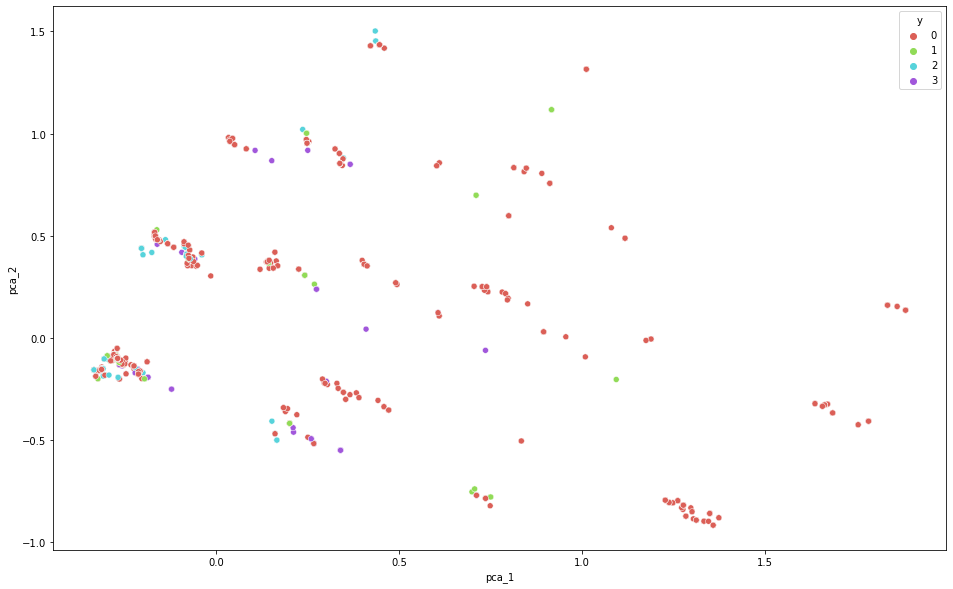

In [57]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca_1", y="pca_2",
    hue="y",
    palette=sns.color_palette("hls", 4),
    data=df,
    legend="full",
)

/tmp/ipykernel_20358/466781218.py:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


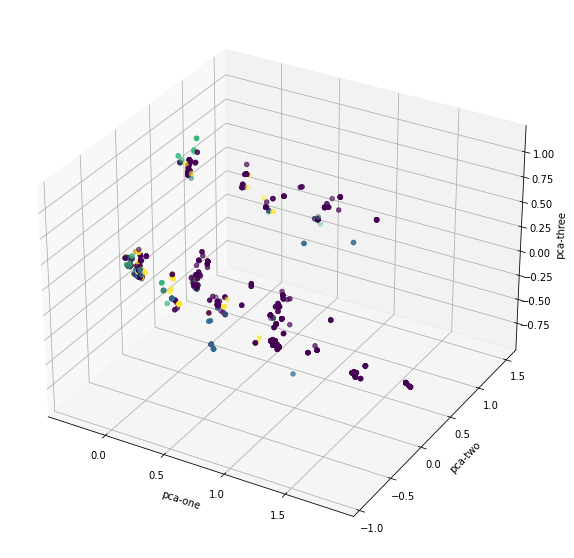

In [41]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["pca_1"], 
    ys=df["pca_2"], 
    zs=df["pca_3"], 
    c=df["y"], 
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')

plt.show()


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.001s...
[t-SNE] Computed neighbors for 2662 samples in 0.234s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.626122
[t-SNE] KL divergence after 300 iterations: 1.610641


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.001s...
[t-SNE] Computed neighbors for 2662 samples in 0.110s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 104.724747
[t-SNE] KL divergence after 300 iterations: 3.578948


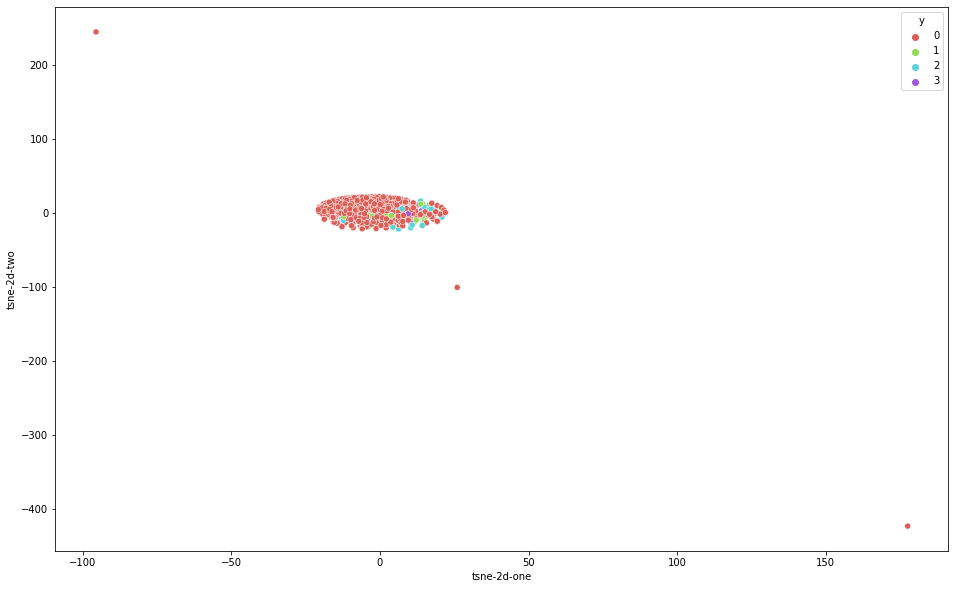

[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.088s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.851097
[t-SNE] KL divergence after 300 iterations: 2.939901


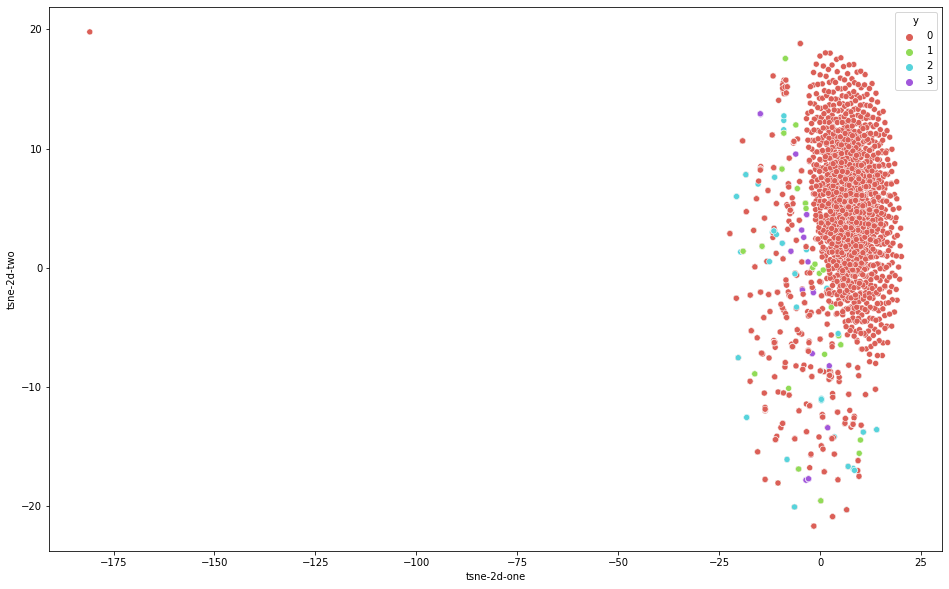

[t-SNE] Computing 22 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.088s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 100.836342
[t-SNE] KL divergence after 300 iterations: 2.684211


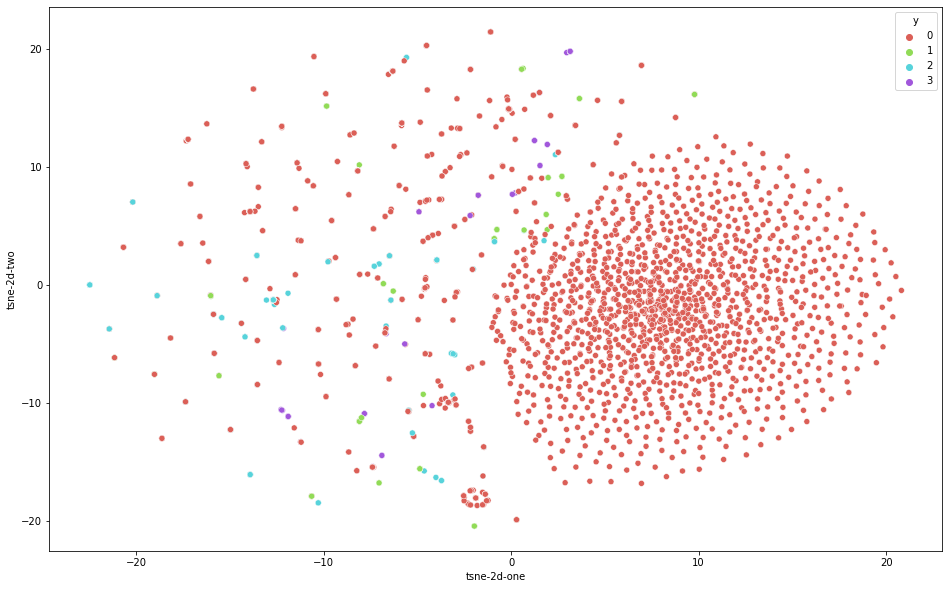

[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.088s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.192123
[t-SNE] KL divergence after 300 iterations: 2.928014


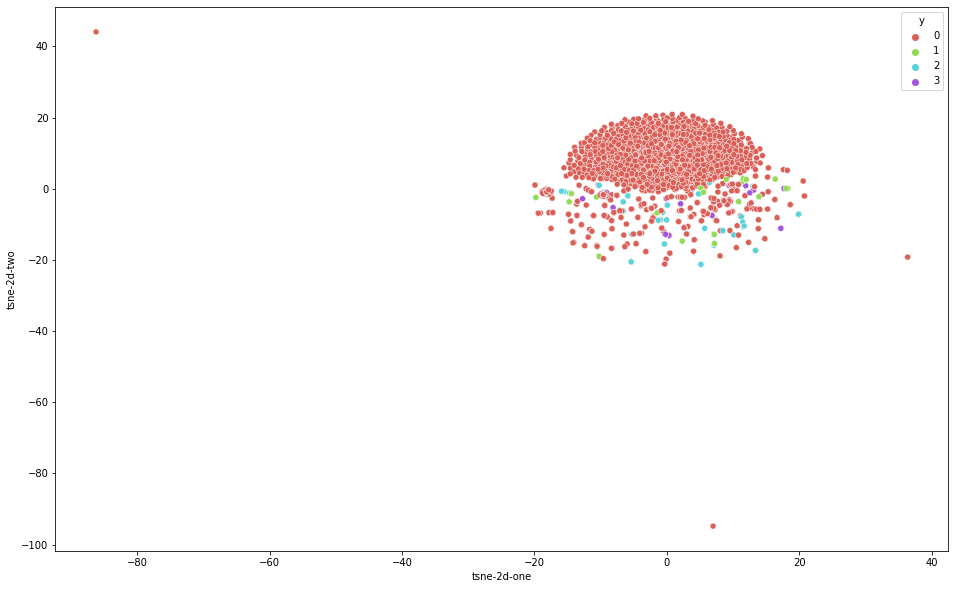

[t-SNE] Computing 28 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.088s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.390472
[t-SNE] KL divergence after 300 iterations: 2.533853


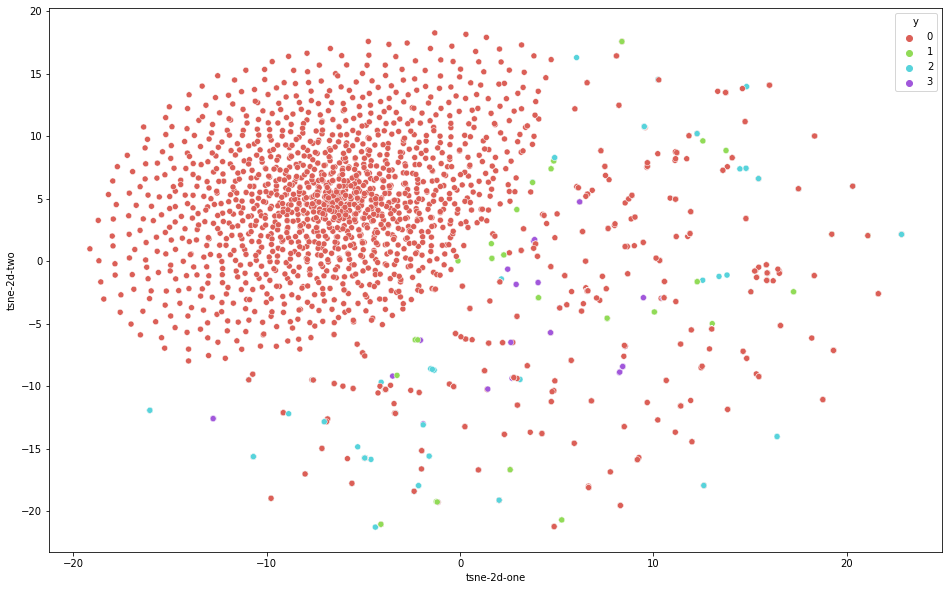

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.089s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.659836
[t-SNE] KL divergence after 300 iterations: 2.510014


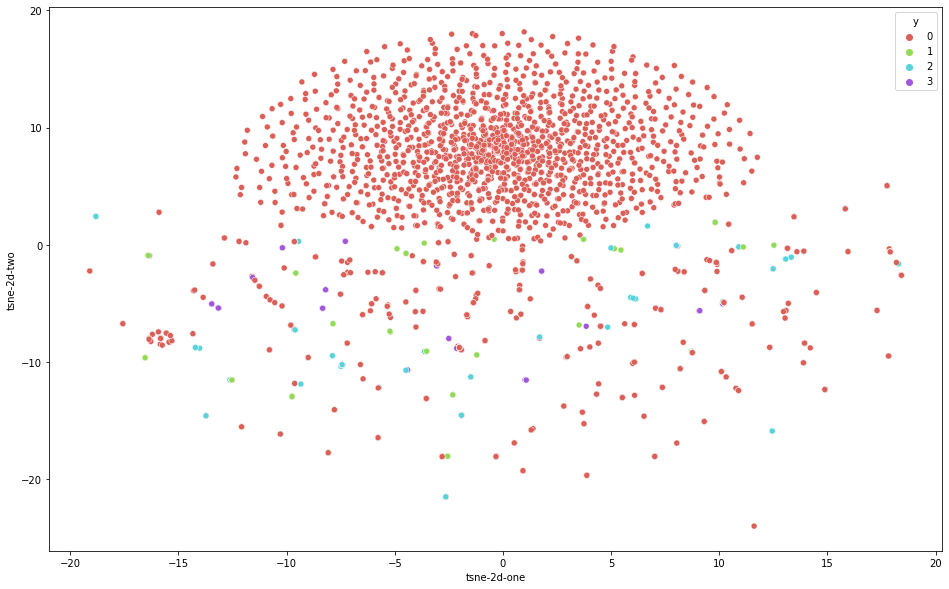

[t-SNE] Computing 34 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.094s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.880821
[t-SNE] KL divergence after 300 iterations: 2.635726


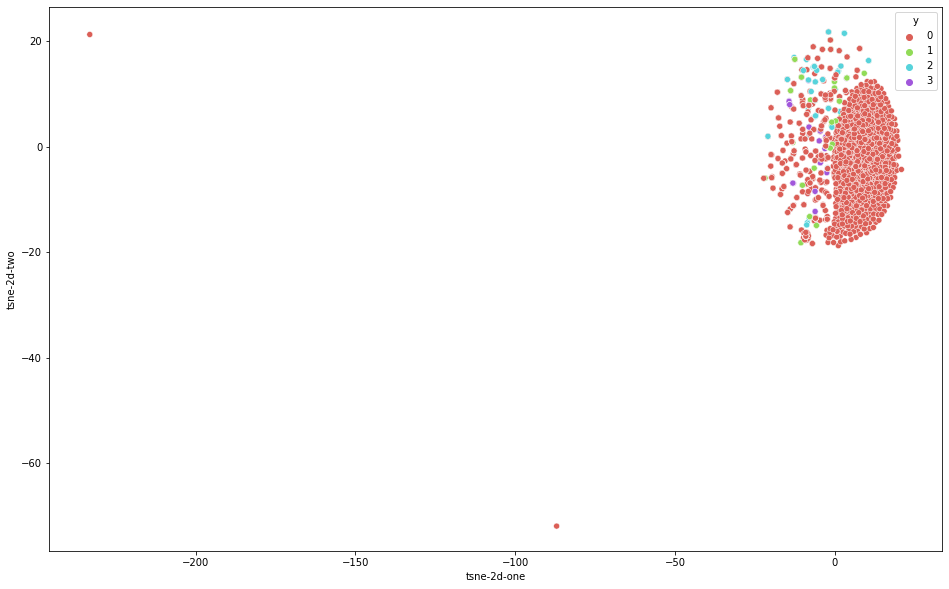

[t-SNE] Computing 37 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.091s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.844482
[t-SNE] KL divergence after 300 iterations: 2.486932


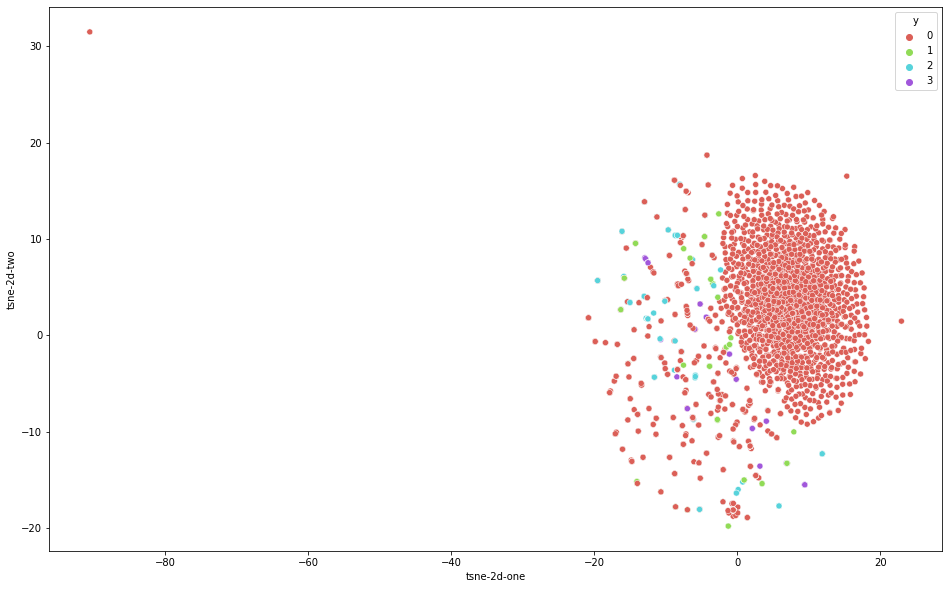

[t-SNE] Computing 40 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.090s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.986069
[t-SNE] KL divergence after 300 iterations: 2.394814


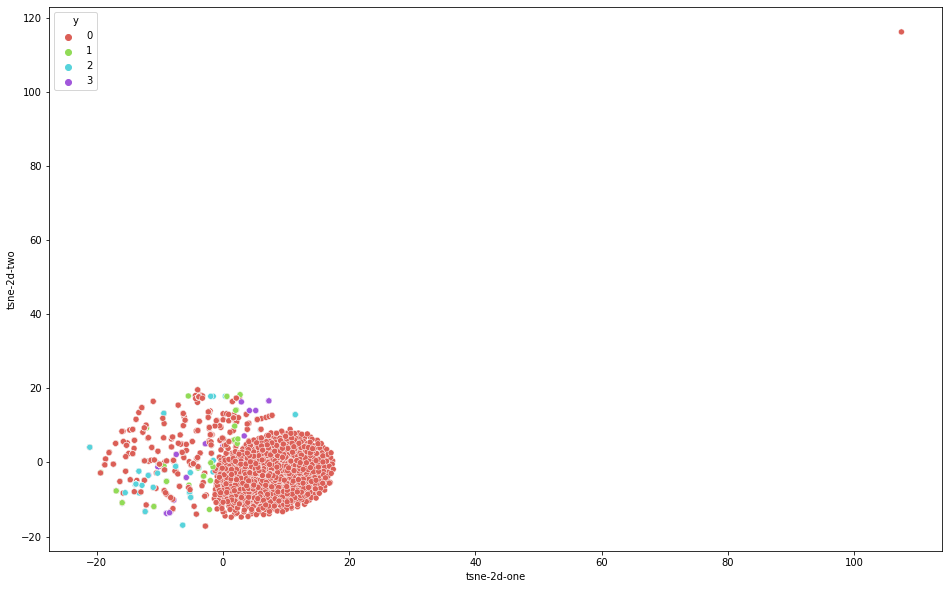

[t-SNE] Computing 43 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.091s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.244225
[t-SNE] KL divergence after 300 iterations: 2.330600


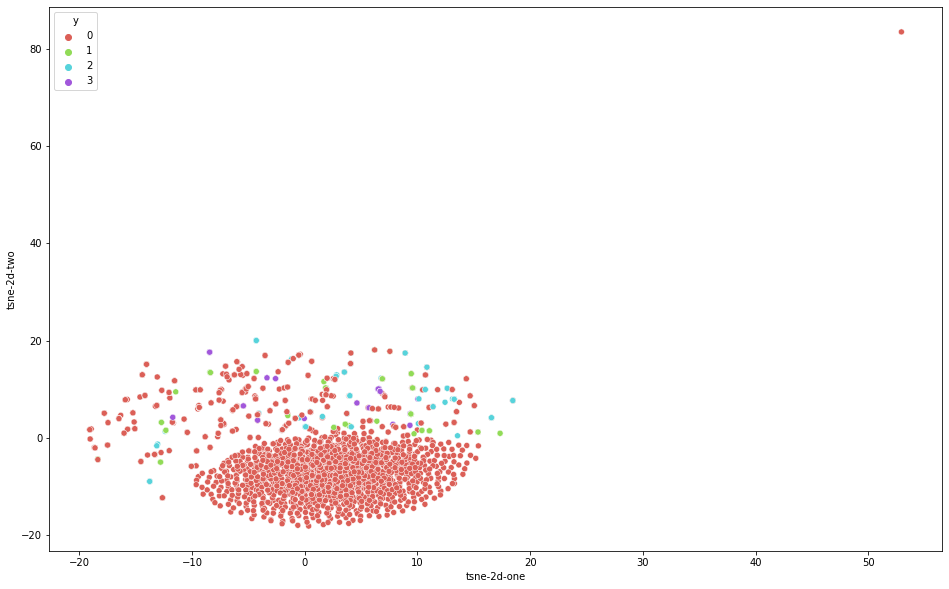

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.094s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.320312
[t-SNE] KL divergence after 300 iterations: 2.365248


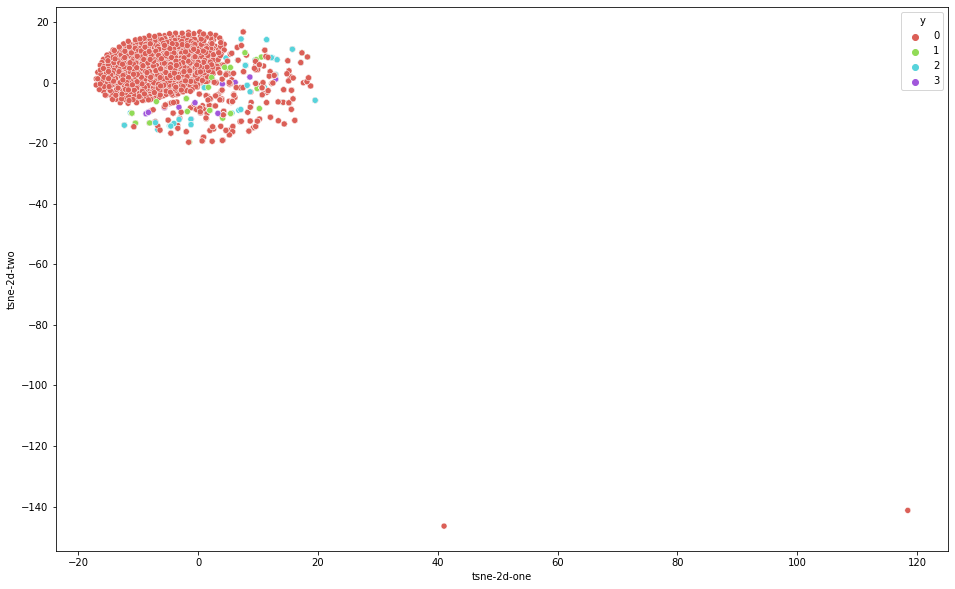

[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.092s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.314079
[t-SNE] KL divergence after 300 iterations: 2.248851


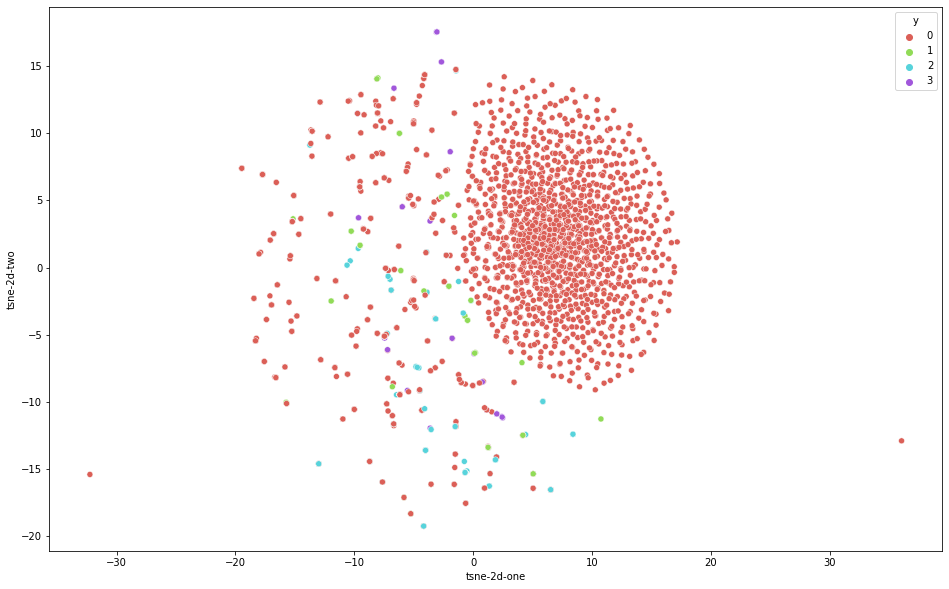

[t-SNE] Computing 52 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.092s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.504471
[t-SNE] KL divergence after 300 iterations: 2.139103


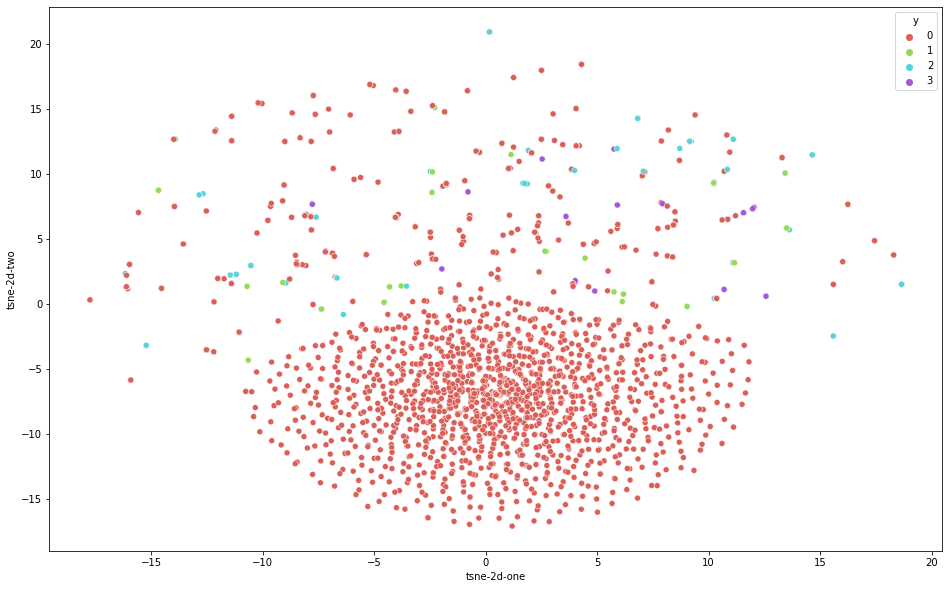

[t-SNE] Computing 55 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.092s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.689453
[t-SNE] KL divergence after 300 iterations: 2.106014


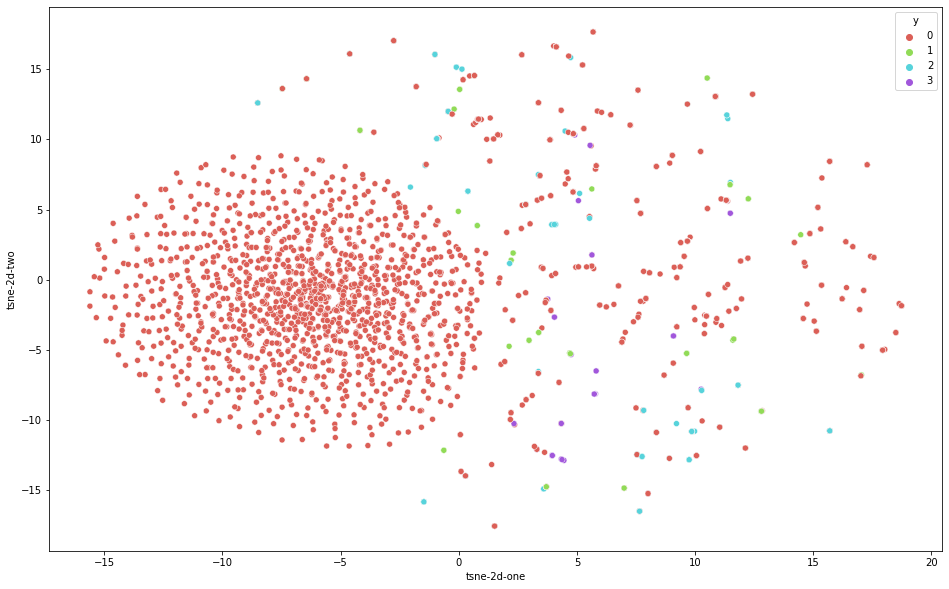

[t-SNE] Computing 58 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.092s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.846245
[t-SNE] KL divergence after 300 iterations: 2.154785


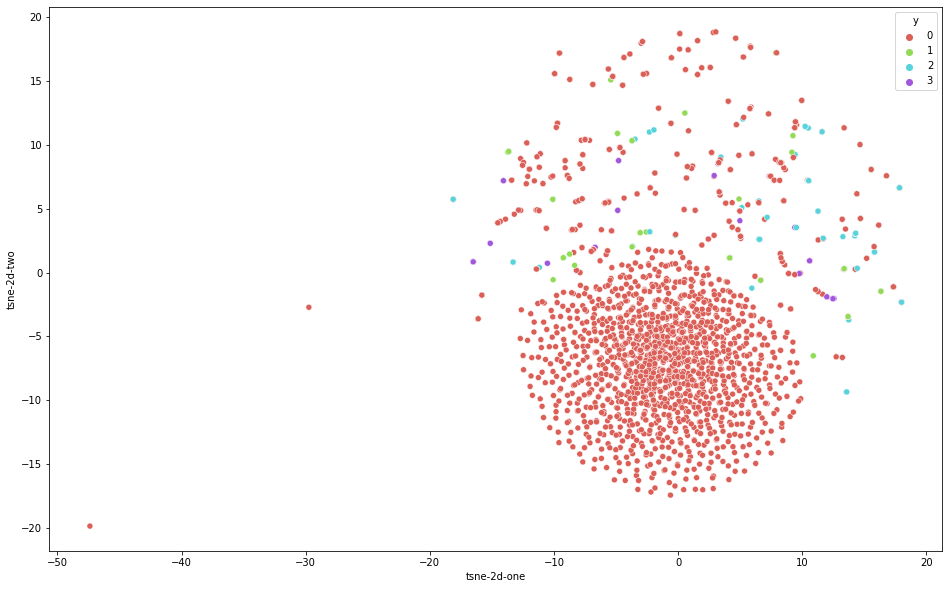

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.093s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.731461
[t-SNE] KL divergence after 300 iterations: 2.049446


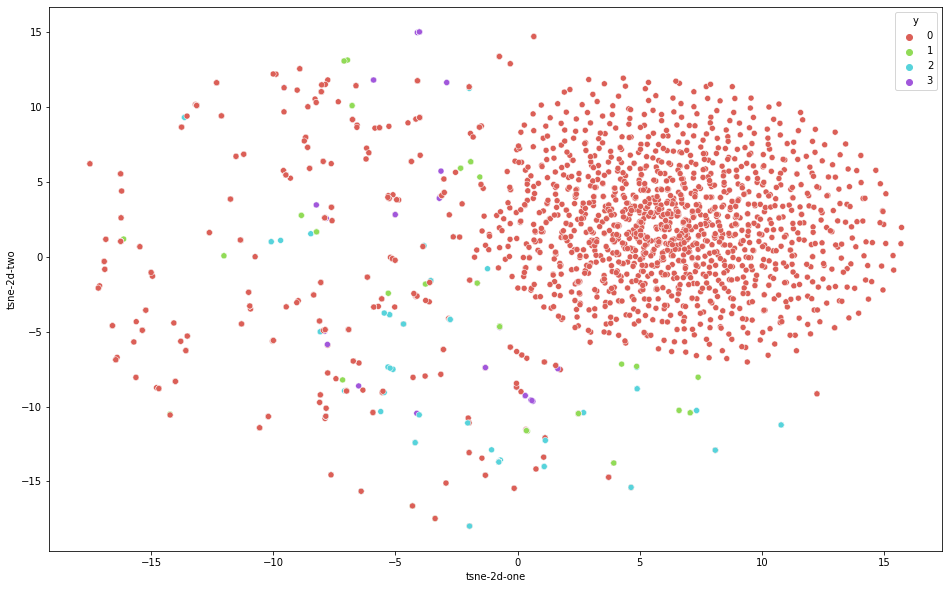

[t-SNE] Computing 64 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.094s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.947350
[t-SNE] KL divergence after 300 iterations: 2.110234


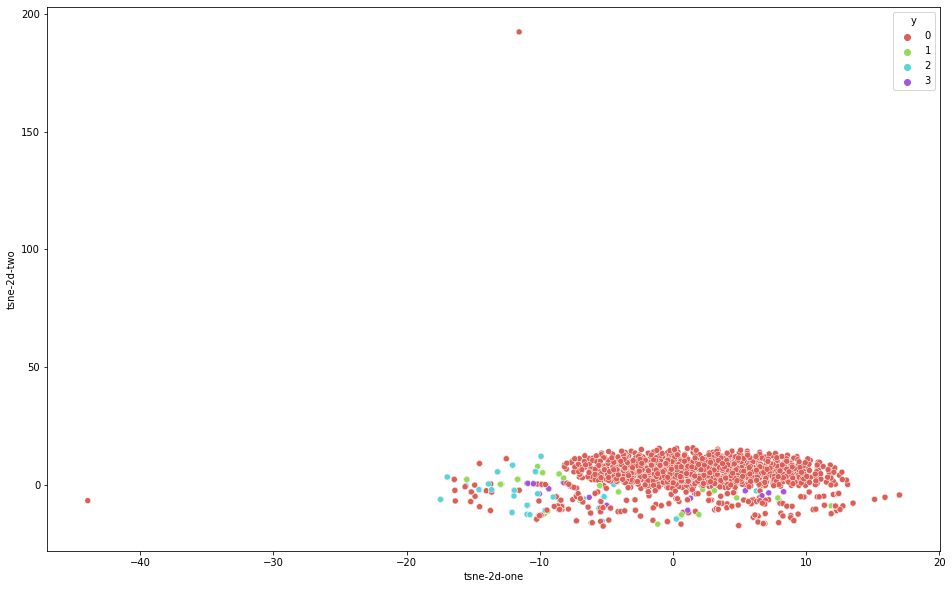

[t-SNE] Computing 67 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.093s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.359535
[t-SNE] KL divergence after 300 iterations: 1.974415


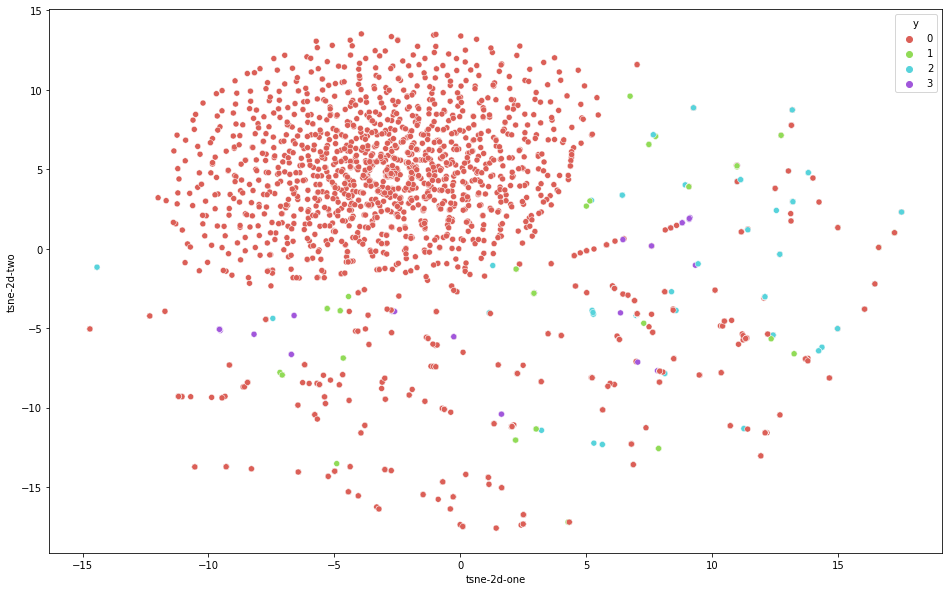

[t-SNE] Computing 70 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.100s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.490921
[t-SNE] KL divergence after 300 iterations: 2.008507


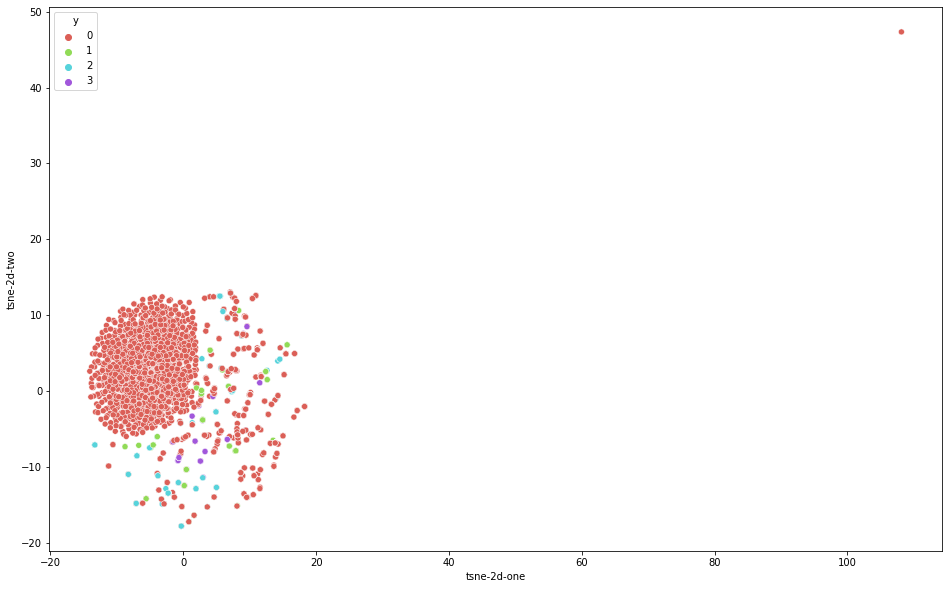

[t-SNE] Computing 73 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.094s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.672356
[t-SNE] KL divergence after 300 iterations: 2.010872


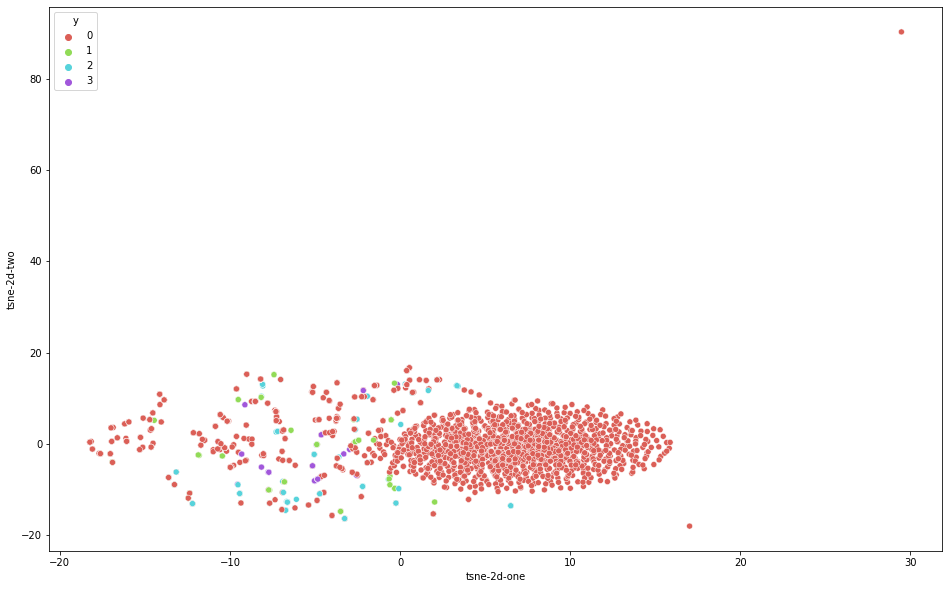

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.094s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.586487
[t-SNE] KL divergence after 300 iterations: 1.907077


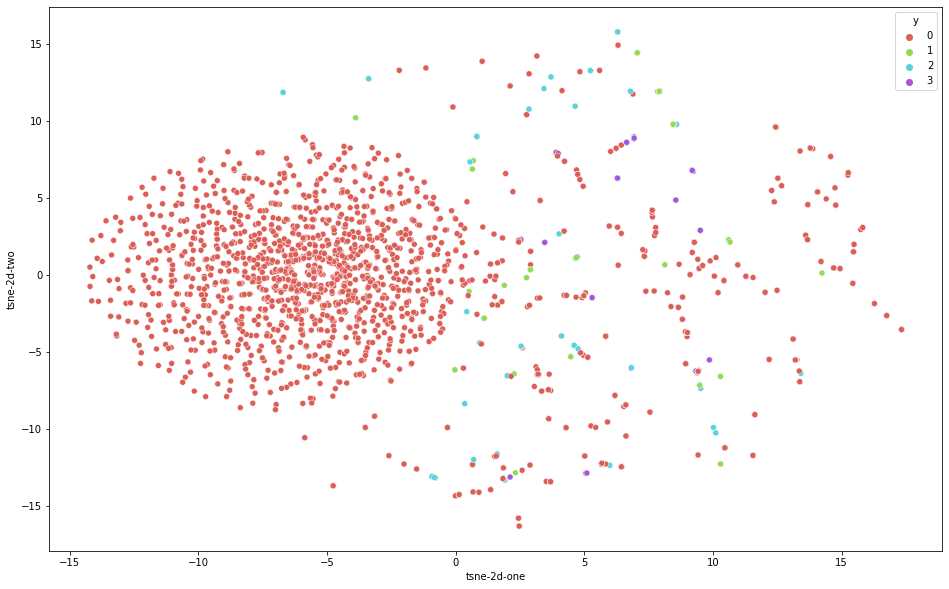

[t-SNE] Computing 79 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.095s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.081985
[t-SNE] KL divergence after 300 iterations: 1.928412


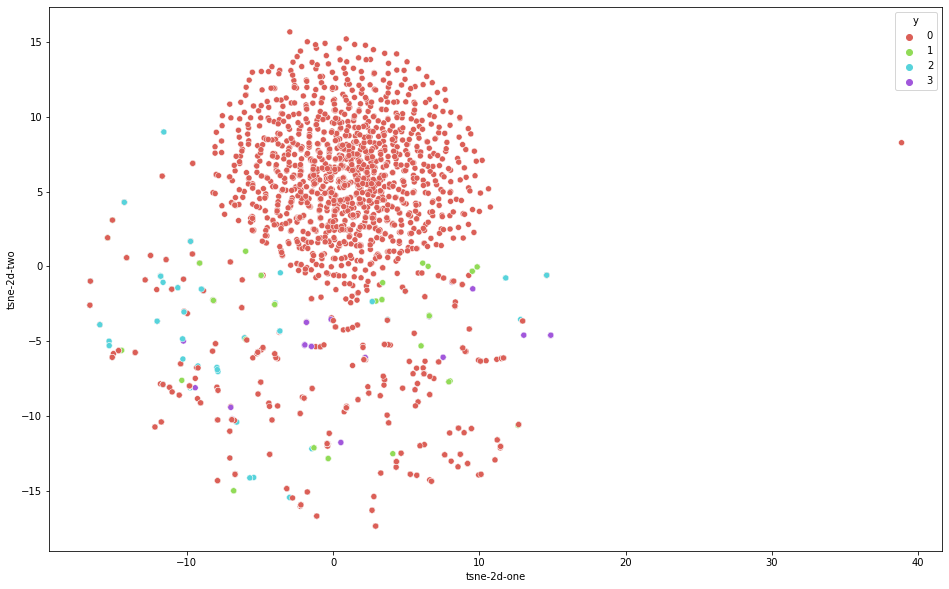

[t-SNE] Computing 82 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.096s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.298576
[t-SNE] KL divergence after 300 iterations: 1.882922


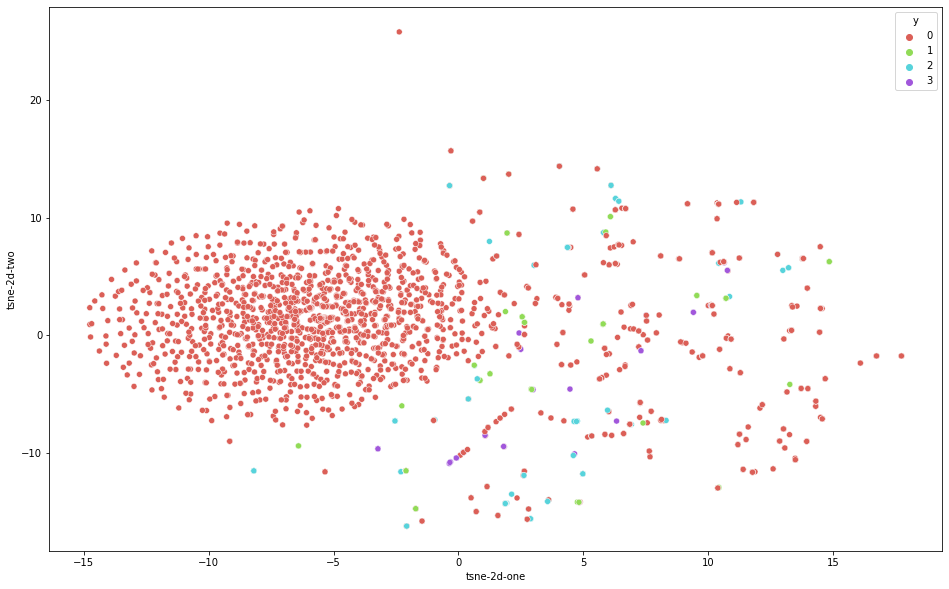

[t-SNE] Computing 85 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.095s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.617599
[t-SNE] KL divergence after 300 iterations: 1.841649


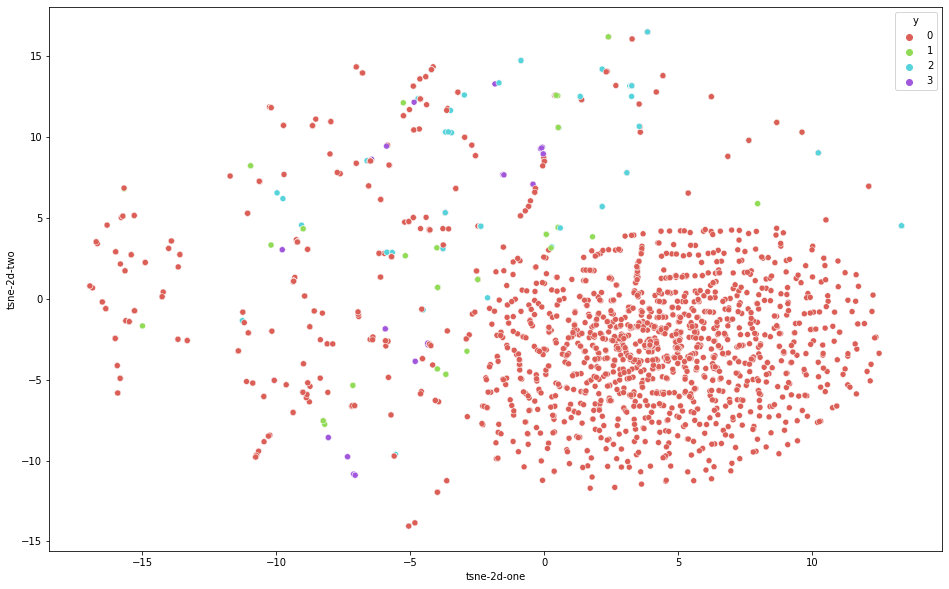

[t-SNE] Computing 88 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.097s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.933174
[t-SNE] KL divergence after 300 iterations: 1.822905


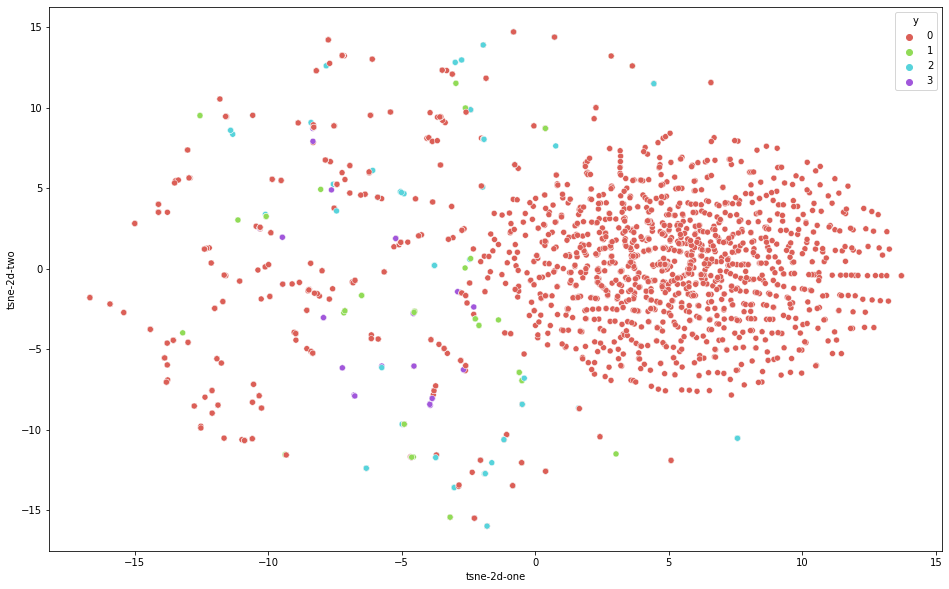

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.096s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.388496
[t-SNE] KL divergence after 300 iterations: 1.842199


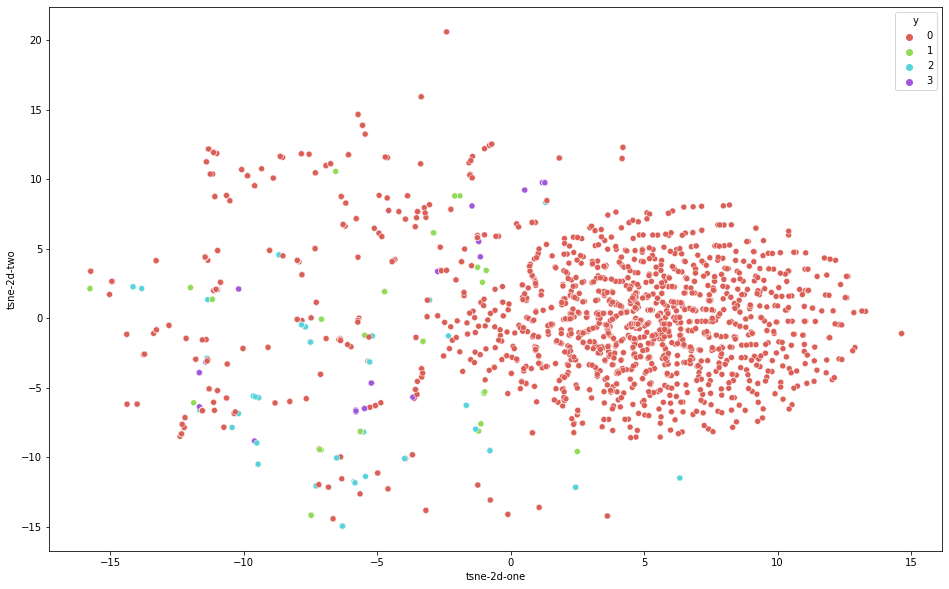

[t-SNE] Computing 94 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.097s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.683067
[t-SNE] KL divergence after 300 iterations: 1.818592


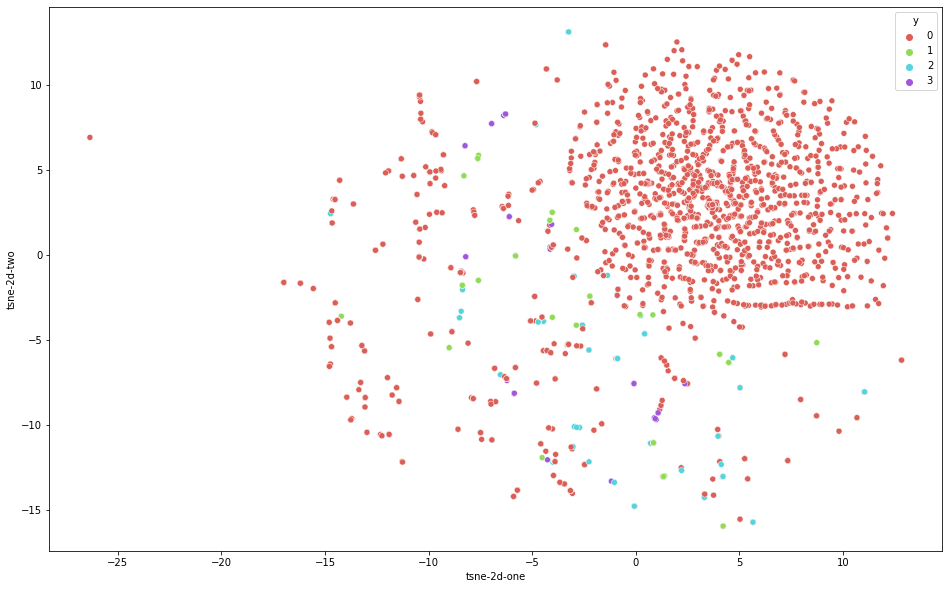

[t-SNE] Computing 97 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.097s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.514175
[t-SNE] KL divergence after 300 iterations: 1.782642


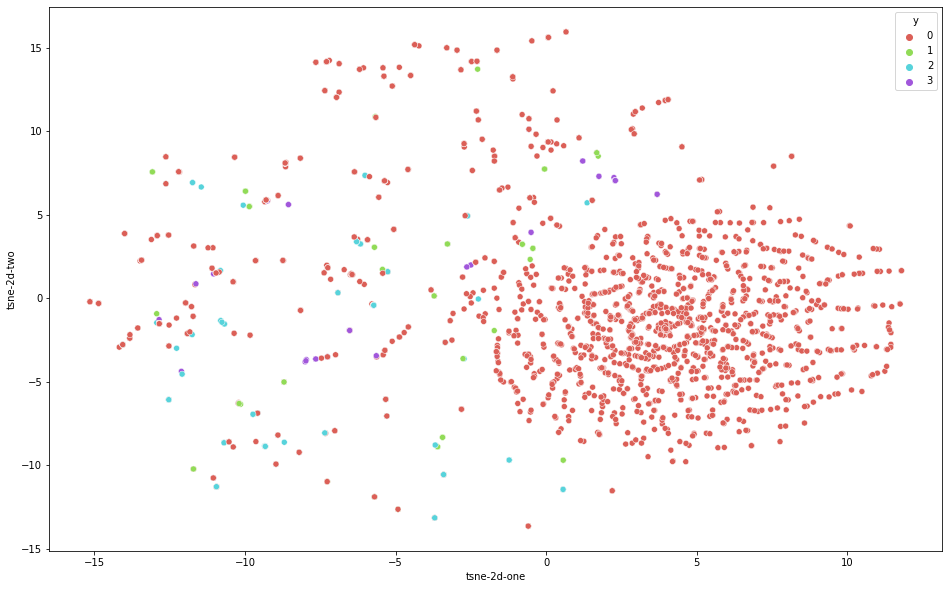

[t-SNE] Computing 100 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.098s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.910553
[t-SNE] KL divergence after 300 iterations: 1.764764


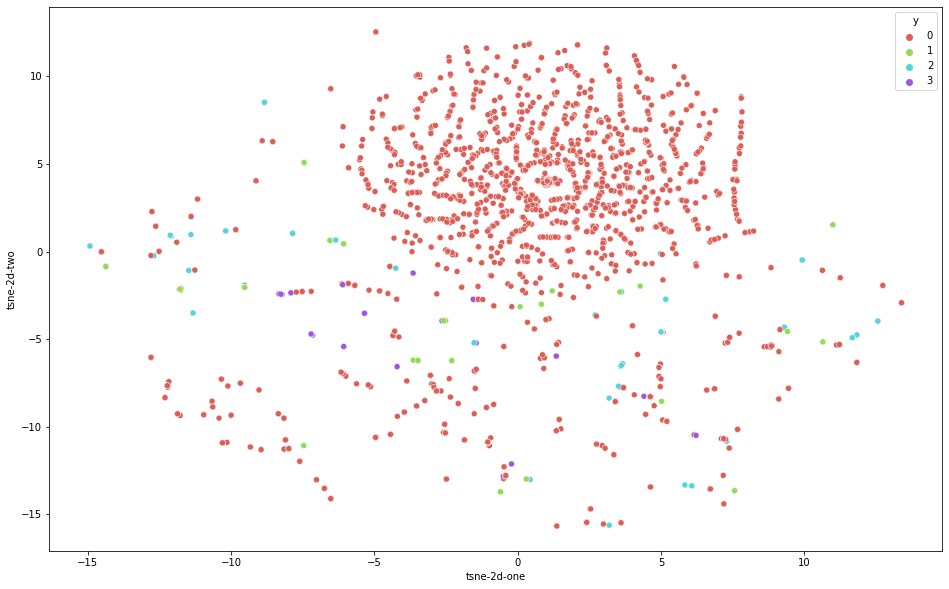

[t-SNE] Computing 103 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.100s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.516327
[t-SNE] KL divergence after 300 iterations: 1.751091


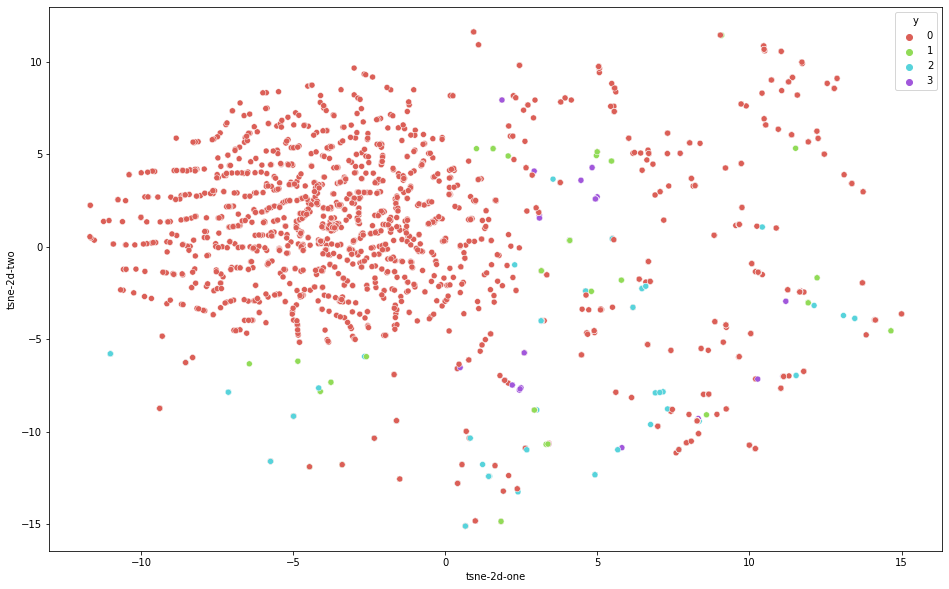

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.100s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.300285
[t-SNE] KL divergence after 300 iterations: 1.720375


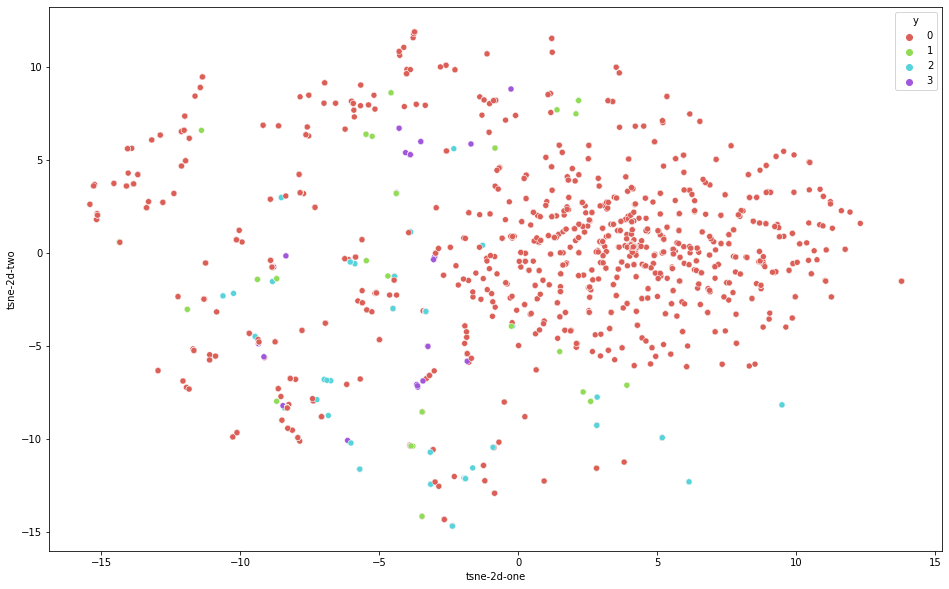

[t-SNE] Computing 109 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.105s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.255386
[t-SNE] KL divergence after 300 iterations: 1.733077


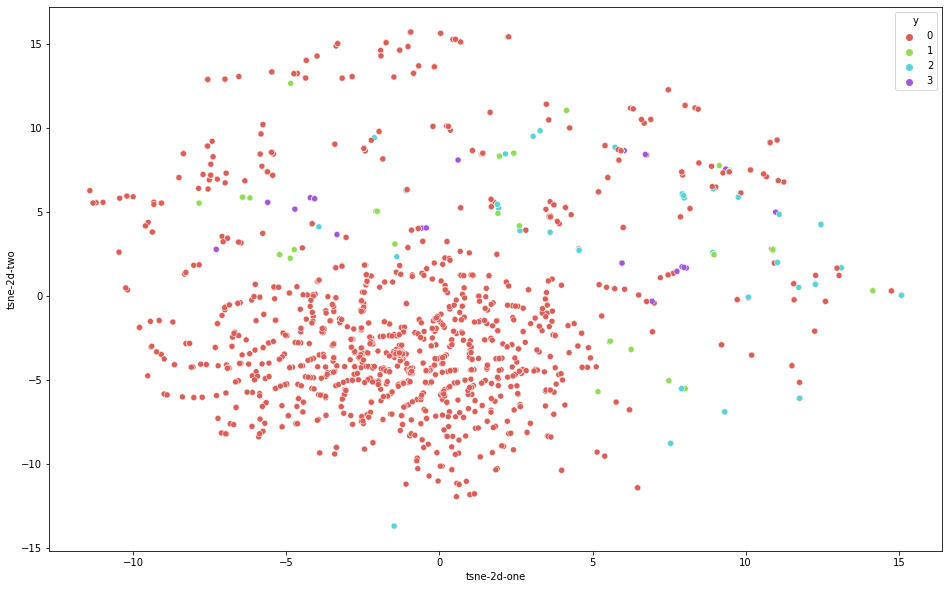

[t-SNE] Computing 112 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.098s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000


KeyboardInterrupt: 

In [50]:
for perp in range(5,50):
    tsne = TSNE(n_components=10, verbose=1, perplexity=perp, n_iter=300)
    tsne_results = tsne.fit_transform(X)
    df['tsne-2d-one'] = tsne_results[:,0]
    df['tsne-2d-two'] = tsne_results[:,1]
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("hls", 4),
        data=df,
        legend="full",
    )
    plt.show()

[t-SNE] Computing 97 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.001s...
[t-SNE] Computed neighbors for 2662 samples in 0.120s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.380547
[t-SNE] KL divergence after 300 iterations: 1.788001


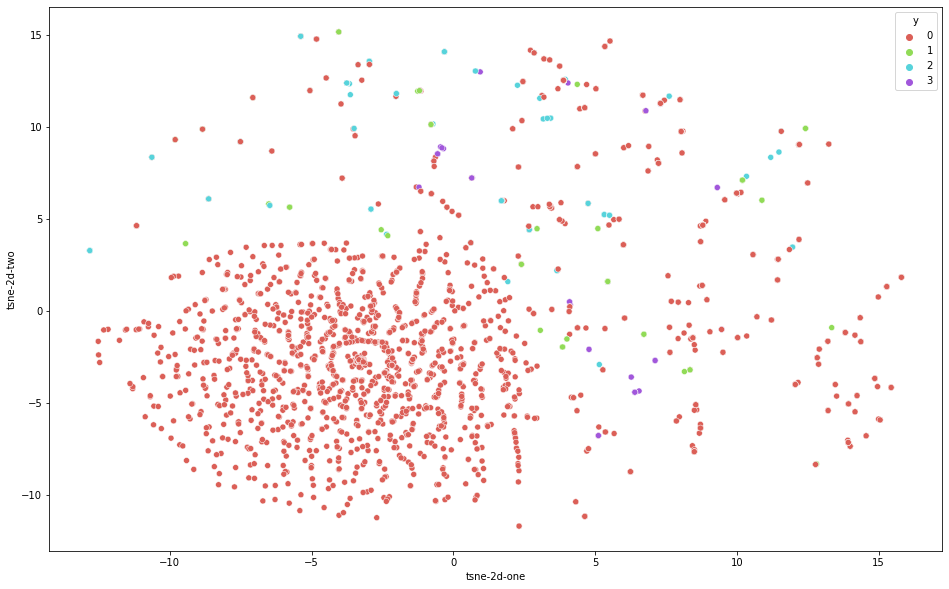

In [56]:
tsne = TSNE(n_components=2, verbose=1, perplexity=32, n_iter=300)
tsne_results = tsne.fit_transform(X)
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 4),
    data=df,
    legend="full",
)
plt.show()